In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [41]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import cv2

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!rm -rf 'ProgressBar'
!git clone -q https://github.com/dvolynov/ProgressBar
from ProgressBar.Progress import Bar

In [4]:
FOLDER = '/content/drive/MyDrive/Development'

In [5]:
IMG_SHAPE = (256, 256, 3)

In [ ]:
!rm -rf 'Prepared_dataset'
!unzip -q {FOLDER + "/Dataset/prepared_skoltech_full.zip"}

In [ ]:
x_folder_path = "/content/Prepared_dataset/x"
y_folder_path = "/content/Prepared_dataset/y"

In [ ]:
n_start, n_end = 6000, 9000

x_array = np.array([np.load(f"{x_folder_path}/{i}") for i in sorted(os.listdir(x_folder_path)[n_start: n_end])]).astype(np.uint8)
y_array = np.array([np.load(f"{y_folder_path}/{i}") for i in sorted(os.listdir(y_folder_path)[n_start: n_end])]).astype(np.uint8)

In [ ]:
x_array, y_array = shuffle(x_array, y_array)

In [ ]:
x_train = x_array[:-100]
y_train = y_array[:-100]

x_test = x_array[-100:]
y_test = y_array[-100:]

In [ ]:
print("x:", x_train.shape)
print("y:", y_train.shape)
print()
print("x:", x_test.shape)
print("y:", y_test.shape)

x: (2900, 256, 256, 3)
y: (2900, 256, 256, 2)

x: (100, 256, 256, 3)
y: (100, 256, 256, 2)


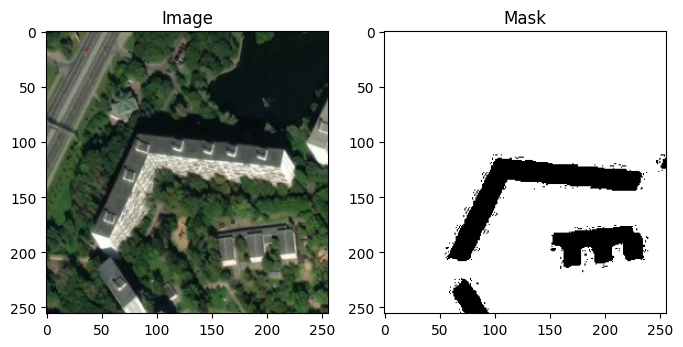

In [ ]:
i = 152
image, mask = Image.fromarray(x_train[i]), y_train[i][:, :, 0]

ig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(image)
axs[0].set_title('Image')
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Mask')
plt.show()

# Model


In [6]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
from keras import backend as K

In [7]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
def build_model(input_shape):
    inputs = Input(input_shape)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    concat5 = concatenate([conv3, up5], axis=-1)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    concat6 = concatenate([conv2, up6], axis=-1)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    concat7 = concatenate([conv1, up7], axis=-1)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat7)

    output = Conv2D(2, (1, 1), activation='softmax')(conv7)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_m])

    return model

In [47]:
model = build_model(IMG_SHAPE)

# Loading weights

In [48]:
model.load_weights(f"{FOLDER}/Weights/skoltech_unet_f1_9492.h5")

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("weights.h5", save_best_only=True)]

history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.2,
    callbacks=[callbacks]
)

Epoch 1/10
145/145 [==============================] - 32s 203ms/step - loss: 0.5985 - f1_m: 0.8920 - val_loss: 0.2166 - val_f1_m: 0.9207
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


145/145 [==============================] - 28s 192ms/step - loss: 0.2259 - f1_m: 0.9130 - val_loss: 0.1867 - val_f1_m: 0.9280
Epoch 3/10
145/145 [==============================] - 28s 191ms/step - loss: 0.2133 - f1_m: 0.9163 - val_loss: 0.1922 - val_f1_m: 0.9298
Epoch 4/10
145/145 [==============================] - 28s 194ms/step - loss: 0.1971 - f1_m: 0.9228 - val_loss: 0.1840 - val_f1_m: 0.9254
Epoch 5/10
145/145 [==============================] - 28s 194ms/step - loss: 0.1908 - f1_m: 0.9238 - val_loss: 0.1685 - val_f1_m: 0.9343
Epoch 6/10
145/145 [==============================] - 28s 196ms/step - loss: 0.1809 - f1_m: 0.9286 - val_loss: 0.1576 - val_f1_m: 0.9381
Epoch 7/10
145/145 [==============================] - 28s 193ms/step - loss: 0.1749 - f1_m: 0.9310 - val_loss: 0.1565 - val_f1_m: 0.9384
Epoch 8/10
145/145 [==============================] - 29s 198ms/step - loss: 0.1680 - f1_m: 0.9332 - val_loss: 0.1500 - val_f1_m: 0.9407
Epoch 9/10
145/145 [==============================] 

In [ ]:
plt.plot(history.history['f1_m'], label='f1_m')
plt.plot(history.history['val_f1_m'], label='val_f1_m')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Training History')
plt.legend()
plt.show()

# Predicts functions

In [35]:
import math

In [25]:
def index2color(index):
    return [0, 0, 0] if np.argmax(index) == 0 else [255, 0, 0]

In [98]:
def predict_net(image):
    np_img = keras.utils.img_to_array(image)
    np_img = np_img.reshape(1, *IMG_SHAPE)
    mask = np.array(model(np_img)[0]).reshape(-1, 2)
    mask = np.array([index2color(i) for i in mask])
    mask = mask.reshape(*IMG_SHAPE).astype('uint8')
    mask = Image.fromarray(mask)
    return mask

In [92]:
def combine_masks(masks, image_size):
    result_image = Image.new("RGB", image_size, color=0)

    for box, mask in masks:
        result_image.paste(mask, box)

    return result_image

In [54]:
def remove_small_buildings(mask, threshold_area=100):
    gray_mask = cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY)

    kernel = np.ones((5, 5), np.uint8)
    opened_mask = cv2.morphologyEx(gray_mask, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(opened_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area = cv2.contourArea(contour)
        if area < threshold_area:
            cv2.drawContours(opened_mask, [contour], -1, 0, thickness=cv2.FILLED)

    return Image.fromarray(opened_mask)

In [107]:
def predict(x_test_path, y_test_path, block_size):
    x_img = Image.open(x_test_path)
    y_img = Image.open(y_test_path)

    width, height = x_img.size

    n = int(math.ceil(height / block_size) * math.ceil(width / block_size))

    bar = Bar(n)

    masks = []
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            box = (x, y, x + block_size, y + block_size)
            region = x_img.crop(box)
            mask = predict_net(region)
            masks.append((box, mask))
            bar.next()

    mask = combine_masks(masks, y_img.size)
    mask = remove_small_buildings(mask)

    return x_img, mask, y_img

In [108]:
def show(x_img, mask, y_img):
    x = Image.open(x_test_path)
    y = Image.open(y_test_path)

    ig, axs = plt.subplots(1, 3, figsize=(18, 10))
    axs[0].imshow(x)
    axs[0].set_title('Image')
    axs[1].imshow(mask, cmap='Greys')
    axs[1].set_title('Predict')
    axs[2].imshow(y.convert('L'), cmap='Greys')
    axs[2].set_title('Answer')
    plt.show()

# Using test data

In [109]:
x_test_path = f"{FOLDER}/Dataset/Test/image/train_image_001.jpg"
y_test_path = f"{FOLDER}/Dataset/Test/mask/train_mask_001.jpg"

In [110]:
x_img, mask, y_img = predict(x_test_path, y_test_path, block_size=IMG_SHAPE[0])

360/360 [==============================] 100%


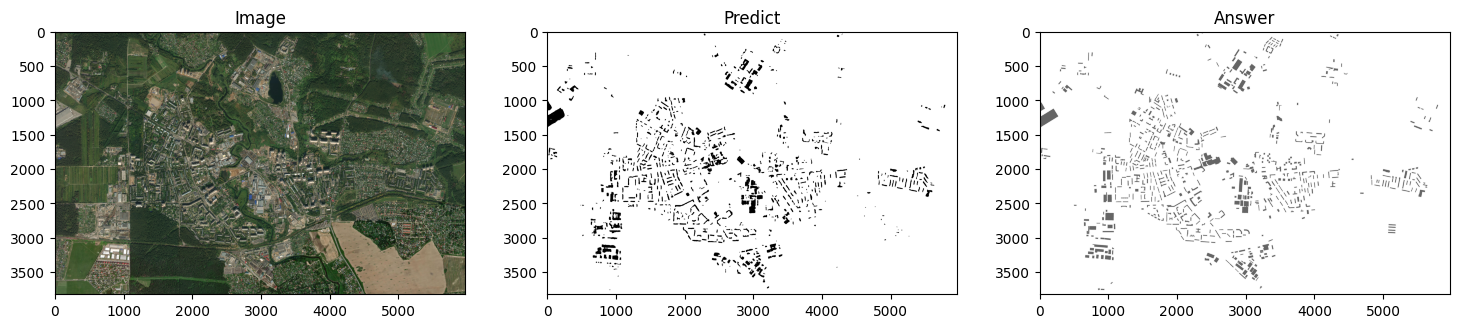

In [111]:
show(x_img, mask, y_img)